
# Agricultural Yield Modeling with Statistical Learning

Upload **dataset.csv** to Colab before running.

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, classification_report, accuracy_score
from scipy import stats

plt.rcParams["figure.figsize"] = (8,5)


In [7]:

df = pd.read_csv("/content/dataset.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (3158, 12)


,Year,Location,Area,Rainfall,Temperature,Soil type,Irrigation,yeilds,Humidity,Crops,price,Season
0,2004,Mangalore,1279,2903.1,27.0,Alluvial,Drip,2570.0,57.0,Coconut,200000,Kharif
1,2004,Mangalore,13283,2903.1,27.0,Alluvial,Drip,27170.0,57.5,Coconut,4847,Kharif
2,2004,Mangalore,52119,2903.1,27.0,Alluvial,Drip,114744.0,57.0,Coconut,51239,Kharif
3,2004,Mangalore,725,2996.6,27.0,Alluvial,Drip,1402.0,55.0,Coconut,216396,Kharif
4,2004,Mangalore,12885,2996.6,27.0,Alluvial,Drip,23456.0,56.0,Coconut,2644,Kharif


In [8]:

target = "yeilds"
X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)


In [9]:

num_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_tree = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

pre_scaled = ColumnTransformer([
    ("num", num_scaled, num_cols),
    ("cat", cat_pipe, cat_cols)
])

pre_tree = ColumnTransformer([
    ("num", num_tree, num_cols),
    ("cat", cat_pipe, cat_cols)
])


In [10]:

lin_model = Pipeline([
    ("prep", pre_scaled),
    ("lr", LinearRegression())
])

lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, lin_preds))
print("Linear Regression RMSE:", mean_squared_error(y_test, lin_preds))


Linear Regression R2: 0.024774033733240053
Linear Regression RMSE: 2496176157.124939


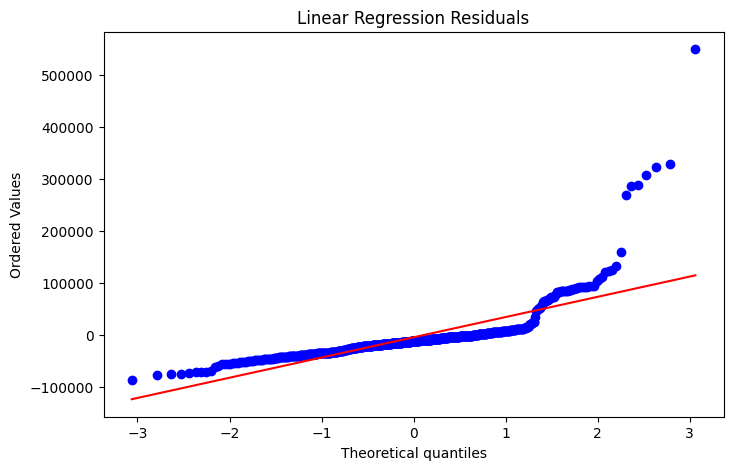

In [11]:

res = y_test - lin_preds
stats.probplot(res, plot=plt)
plt.title("Linear Regression Residuals")
plt.show()


In [12]:

qs = y_train.quantile([0.33, 0.66]).values

def cat_y(v):
    return pd.cut(v, [-np.inf, qs[0], qs[1], np.inf], labels=["Low","Medium","High"])

y_train_cat = cat_y(y_train)
y_test_cat = cat_y(y_test)


In [13]:

log_clf = Pipeline([
    ("prep", pre_scaled),
    ("logreg", LogisticRegression(max_iter=1000, multi_class="multinomial"))
])

log_clf.fit(X_train, y_train_cat)
log_preds = log_clf.predict(X_test)

print(classification_report(y_test_cat, log_preds))


              precision    recall  f1-score   support

        High       0.55      0.56      0.55       189
         Low       0.50      0.45      0.47       202
      Medium       0.56      0.61      0.59       241

    accuracy                           0.54       632
   macro avg       0.54      0.54      0.54       632
weighted avg       0.54      0.54      0.54       632



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [14]:

tree_clf = Pipeline([
    ("prep", pre_tree),
    ("tree", DecisionTreeClassifier(max_depth=5, random_state=123))
])

tree_clf.fit(X_train, y_train_cat)
tree_preds = tree_clf.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test_cat, tree_preds))


Decision Tree Accuracy: 0.5363924050632911


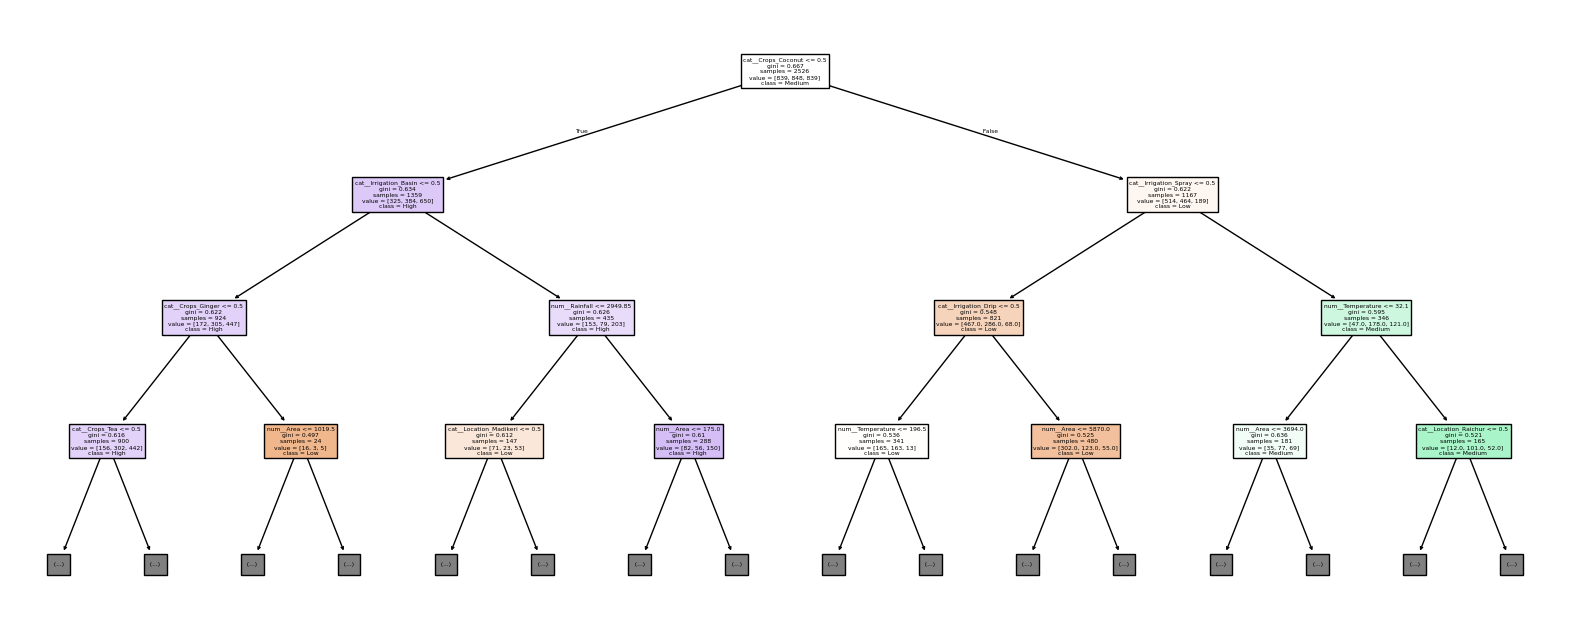

In [15]:

feat_names = tree_clf.named_steps["prep"].get_feature_names_out()

plt.figure(figsize=(20,8))
plot_tree(
    tree_clf.named_steps["tree"],
    feature_names=feat_names,
    class_names=["Low","Medium","High"],
    filled=True,
    max_depth=3
)
plt.show()


In [17]:

rf = Pipeline([
    ("prep", pre_tree),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=123))
])

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest R2:", r2_score(y_test, rf_preds))
print("Random Forest RMSE:", mean_squared_error(y_test, rf_preds))


Random Forest R2: -0.1302347912364774
Random Forest RMSE: 2892934802.2157345


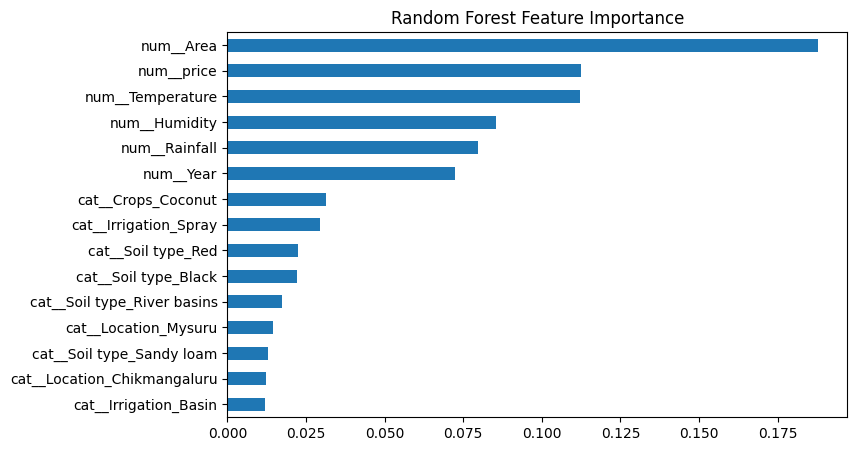

In [18]:

importances = rf.named_steps["rf"].feature_importances_
names = rf.named_steps["prep"].get_feature_names_out()

pd.Series(importances, index=names).sort_values().tail(15).plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.show()
